## Classical Adaline (Adaptive Linear Neuron) for Binary MNIST Classification (NumPy)

This section implements the Adaline network. Adaline is similar to the Perceptron but uses a linear activation function (or identity function $f(x) = x$, which means practically the weighted sums) for weight updates and typically minimizes Mean Squared Error (MSE) using the Delta Rule (gradient descent).

Functions that are defined in previous notebooks, e.g. `compute_weighted_sum` and `step_function`, are imported here to keep it clean.


The Adaline paper by B. Widrow and H. Hoff can be found [here](https://isl.stanford.edu/~widrow/papers/t1960anadaptive.pdf).

In [1]:
# Adaline Helper Functions
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any

from src.utils.load_data import mnist
from src.utils.plot import plot_examples, plot_metrics
from src.preprocessing.data_transforms import normalize, shuffle_data
from src.components.activations import step_function
from src.components.blocks import compute_weighted_sum


%config InlineBackend.figure_format='retina'

train_images, train_labels, test_images, test_labels = mnist()

Dataset MNIST
    Number of datapoints     
    Train:  60000
    Test:   10000
    Source: https://ossci-datasets.s3.amazonaws.com/mnist/



## Binary Classification

In [2]:
binary_compare_labels = [4, 9]

idx2label = dict(enumerate(binary_compare_labels))
label2idx = {label: i for i, label in idx2label.items()}
binary_index = np.isin(train_labels, binary_compare_labels)
binary_train_labels = train_labels[binary_index]
binary_train_images = train_images[binary_index]
bninary_test_index = np.isin(test_labels, binary_compare_labels)
binary_test_labels = test_labels[bninary_test_index]
binary_test_images = test_images[bninary_test_index]

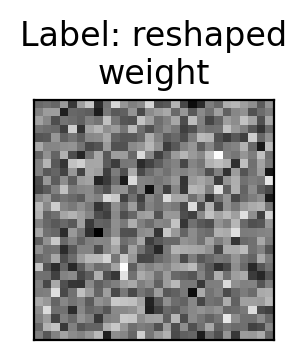

In [3]:
# initialize the weights and bias


def initialize_randn_weights(
    n_inputs: int,
    n_classes: int,
    bias_size: int = 1,
    mean: float = 0,
    std: float = 1,
    seed: int | None = None,
) -> np.ndarray:
    """
    Initialize weights with random values from a normal distribution (mean = 0, variance = 1).

    Args:
        n_inputs (int): Number of input features.
        n_classes (int): Number of output neurons if n_classes >= 2, otherwise it is a binary classification problem.
        bias_size (int): Size of the bias term. Default is 1.
        mean (float): mu or center of the normal distribution. Default is 0.
        std (float): Standard deviation of the normal distribution. Default is 1.
        seed (int | None): Random seed for reproducibility. Default is None.
    Returns:
        np.ndarray: Randomly initialized weights of shape (n_inputs + bias_size, n_outputs).
    """

    if n_classes <= 1:
        raise ValueError(
            "n_classes must be greater than 1 for a classification problem."
        )

    rng = np.random.default_rng(seed) if seed else np.random.default_rng()
    return (
        rng.normal(loc=mean, scale=std, size=(n_inputs + bias_size))
        if n_classes == 2
        else rng.normal(loc=mean, scale=std, size=(n_classes, n_inputs + bias_size))
    )


plot_examples(
    [initialize_randn_weights(784, 2, 0, 0, 0.01).reshape(28, 28)],
    ["reshaped\nweight"],
    num_col=1,
    num_row=1,
)  # (28, 28, 1) is the shape of a single channel image

In [4]:
# inspect the weighted sum after applying the multiplication with the random weights.

compute_weighted_sum(
    normalize(train_images[0], -1, 1).flatten(),
    initialize_randn_weights(784, 2, 1, 0, 0.01),
)

np.float64(0.26541947617172557)

In [5]:
def predict(
    transformed_image: np.ndarray,
    weights: np.ndarray,
    bias_size: int = 1,
    backward=False,
    threshold: float = 0.0,
) -> int | np.float32 | np.ndarray:
    """
    Predict the labels for the input data using the trained weights.

    Args:
        transformed_image (np.ndarray): The input image after transformation.
        weights (np.ndarray): The weights of the perceptron.
        bias_size (int): The size of the bias term.
        backward (bool): If True, return idx otherwise return the label.
        threshold (float): The threshold for the step function. Defaults to 0.0.

    Returns:
        int: The prediction made by the perceptron.
    """
    if len(weights.shape) == 1:
        weighted_sum = compute_weighted_sum(transformed_image, weights, bias_size)

        return (
            weighted_sum
            if backward
            else idx2label.get(step_function(weighted_sum, threshold=threshold).item())
        )

    else:
        # broadcast the multiplication
        preds = compute_weighted_sum(transformed_image, weights.T, bias_size)
        return np.argmax(preds) if not backward else preds


predict(
    normalize(train_images[0], -1, 1).flatten(),
    initialize_randn_weights(784, 2, 1, 0, 0.01),
    backward=False,
    threshold=0.5,
)

4

In [6]:
def mse_loss(y_pred, y_true):
    return 0.5 * np.mean((y_pred - y_true) ** 2)

In [7]:
def one_hot_encoding(y: np.ndarray, num_labels: int = 10) -> np.ndarray:
    """one_hot_encoding assigns the one hot encoding according to the classes.

    Args:
        y (np.ndarray): np.ndarray of the class labels
        num_labels (int, optional): defines the number of different classes. Defaults to 10.

    Returns:
        np.ndarray: the one hot encoding as a vector for each class in the input array
    """
    if y.ndim == 0:
        one_hot = np.zeros(num_labels)
        one_hot[y] = 1.0
    else:
        one_hot = np.zeros((num_labels, y.shape[0]))

        for i, val in enumerate(y):
            one_hot[val, i] = 1.0

    return one_hot


one_hot_encoding(train_labels[0], 10), train_labels[0]

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), np.uint8(5))

In [8]:
def backward_pass(
    transformed_image: np.ndarray,
    y: int,
    weights: np.ndarray,
    learning_rate: float = 0.01,
    bias_size: int = 1,
    threshold: float = 0.5,
) -> Tuple[np.ndarray, float]:
    # binary classification
    # print(weights.shape)
    if len(weights.shape) == 1:
        weighted_sum = predict(transformed_image, weights, bias_size, backward=True)
        error_signal = weighted_sum - label2idx.get(y)
        update = (
            learning_rate
            * error_signal
            * np.hstack((transformed_image, np.ones(bias_size)))
        )
        weights -= update

        # MSE
        loss = mse_loss(weighted_sum, label2idx.get(y))
        pred = idx2label.get(step_function(weighted_sum, threshold=threshold).item())

    else:
        num_classes = weights.shape[0]

        # again broadcast the calculations
        weighted_sums = predict(transformed_image, weights, bias_size, backward=True)
        y_encoded = one_hot_encoding(y, num_classes)

        error_signal = weighted_sums - y_encoded
        update = np.stack(
            [np.hstack((transformed_image, np.ones(bias_size)))] * num_classes
        ) * (error_signal * learning_rate).reshape(num_classes, 1)
        weights -= update

        loss = mse_loss(weighted_sums, y_encoded)
        pred = np.argmax(weighted_sums)

    return weights, loss, pred


weights, loss, pred = backward_pass(
    normalize(binary_train_images[0], -1, 1).flatten(),
    binary_train_labels[0],
    initialize_randn_weights(784, 2, 1, 0, 0.01),
)
print(f"Updated weights: {weights.shape}\nloss: {loss}\nPrediction: {pred}")

Updated weights: (785,)
loss: 0.009776231663770018
Prediction: 4


In [9]:
# train function


def train_adaline(
    X_train: np.ndarray,
    y_train: np.ndarray,
    epochs: int = 10,
    learning_rate: float = 0.01,
    bias_size: int = 1,
) -> Tuple[np.ndarray, Dict[str, Any]]:
    # get the input shape and number of classes
    w_len = X_train[0].flatten().shape[0]
    n_classes = np.unique(y_train).shape[0]
    n_examples = X_train.shape[0]

    # initialize the weights
    weights = initialize_randn_weights(w_len, n_classes, bias_size, 0.0, 0.01)

    train_metrics = {"loss": np.zeros(epochs), "accuracy": np.zeros(epochs)}

    # iterate over the epochs
    for epoch in range(epochs):
        # shuffle the data
        X_train, y_train = shuffle_data(X_train, y_train)

        # epoch metrics
        epoch_loss = 0
        correct_preds = 0

        # iterate over the training data
        for image, label in zip(X_train, y_train):
            # flatten the image
            transformed_image = normalize(image, 0, 1).flatten()

            # compute the backward pass and update the weights (here 'leaarns' the network)
            weights, loss, pred = backward_pass(
                transformed_image,
                label,
                weights,
                learning_rate,
                bias_size,
                threshold=0.5,  # set the threshold between min and max
            )

            # add the loss
            epoch_loss += loss

            # compute the accuracy
            if pred == label:
                correct_preds += 1

        # compute the epoch metrics
        epoch_loss /= n_examples
        epoch_accuracy = correct_preds / n_examples

        # save the metrics
        train_metrics["loss"][epoch] = epoch_loss
        train_metrics["accuracy"][epoch] = epoch_accuracy

        if epoch % (epochs // 10 if epochs >= 10 else 1) == 0 or epoch == epochs - 1:
            print(
                f"Epoch {epoch}: Loss: {epoch_loss:.4f}, Accuracy: {train_metrics['accuracy'][epoch]:.4f}"
            )
    return weights, train_metrics

In [10]:
weights, train_metrics = train_adaline(
    binary_train_images, binary_train_labels, epochs=10, learning_rate=0.0005
)

Epoch 0: Loss: 0.0376, Accuracy: 0.9253
Epoch 1: Loss: 0.0291, Accuracy: 0.9526
Epoch 2: Loss: 0.0276, Accuracy: 0.9545
Epoch 3: Loss: 0.0268, Accuracy: 0.9572
Epoch 4: Loss: 0.0262, Accuracy: 0.9562
Epoch 5: Loss: 0.0259, Accuracy: 0.9598
Epoch 6: Loss: 0.0254, Accuracy: 0.9617
Epoch 7: Loss: 0.0254, Accuracy: 0.9604
Epoch 8: Loss: 0.0252, Accuracy: 0.9603
Epoch 9: Loss: 0.0250, Accuracy: 0.9624


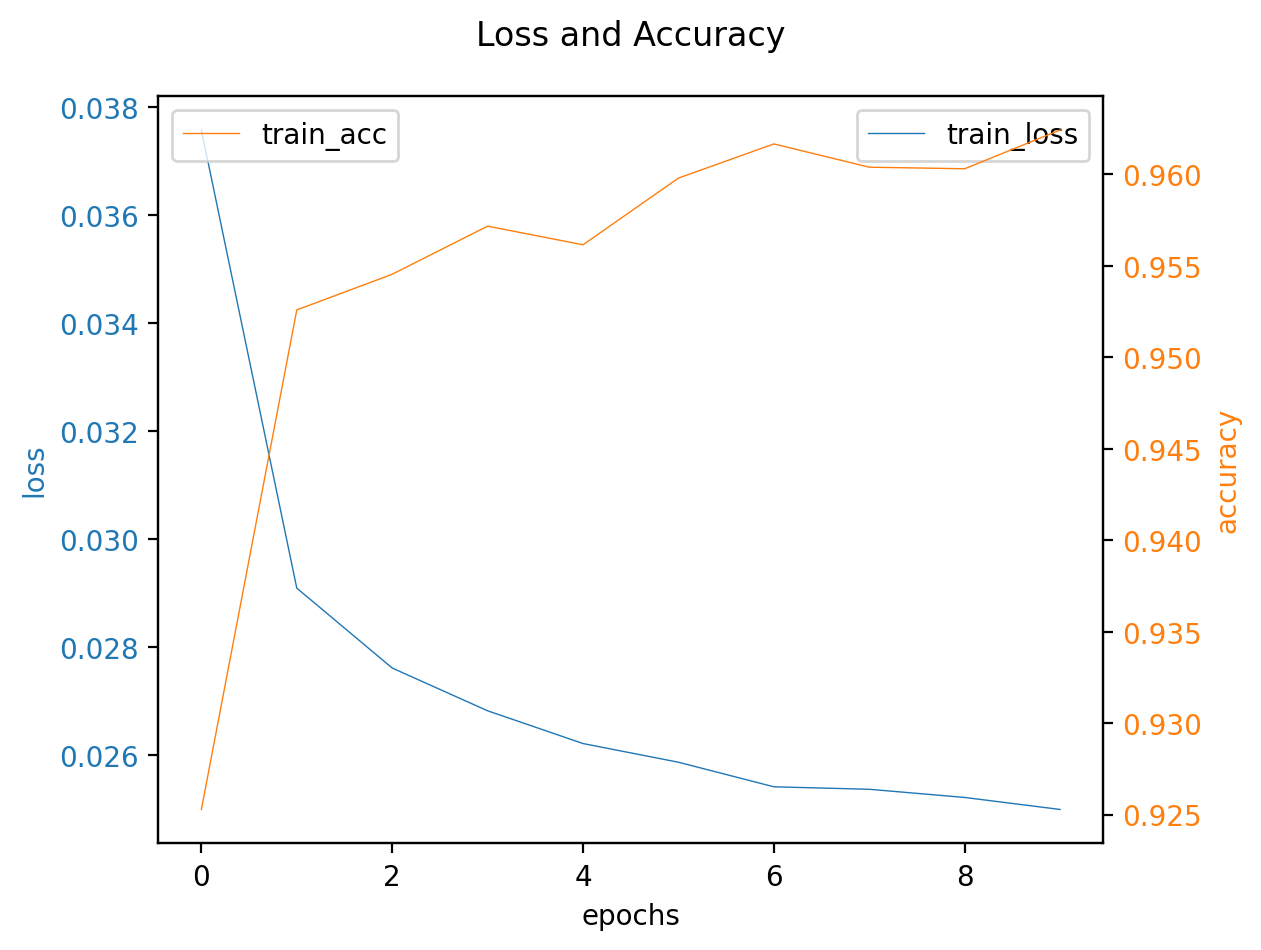

In [11]:
plot_metrics(train_metrics)

In [12]:
def eval_adaline(
    X_test: np.ndarray,
    y_test: np.ndarray,
    weights: np.ndarray,
    bias_size: int = 1,
    threshold: float = 0.0,
) -> tuple:
    """eval evaluates the neural network using the test data.

    Args:
        X_test (np.ndarray): test data
        y_test (np.ndarray): test labels
        weights (np.ndarray): weights
        bias_size (int, optional): size of the bias. Defaults to 1.
        threshold (float, optional): threshold for the step function. Defaults to 0.0.

    Returns:
        tuple: accuracy and predictions
    """
    predictions = np.zeros(X_test.shape[0], dtype=np.int8)
    X_test = normalize(X_test, 0, 1)

    for i, image in enumerate(X_test):
        predictions[i] = predict(
            image.flatten(), weights, bias_size, backward=False, threshold=threshold
        )

    return np.sum(predictions == y_test) / len(y_test)


# evaluate the perceptron
accuracy = eval_adaline(
    binary_test_images, binary_test_labels, weights, bias_size=1, threshold=0.5
)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.962


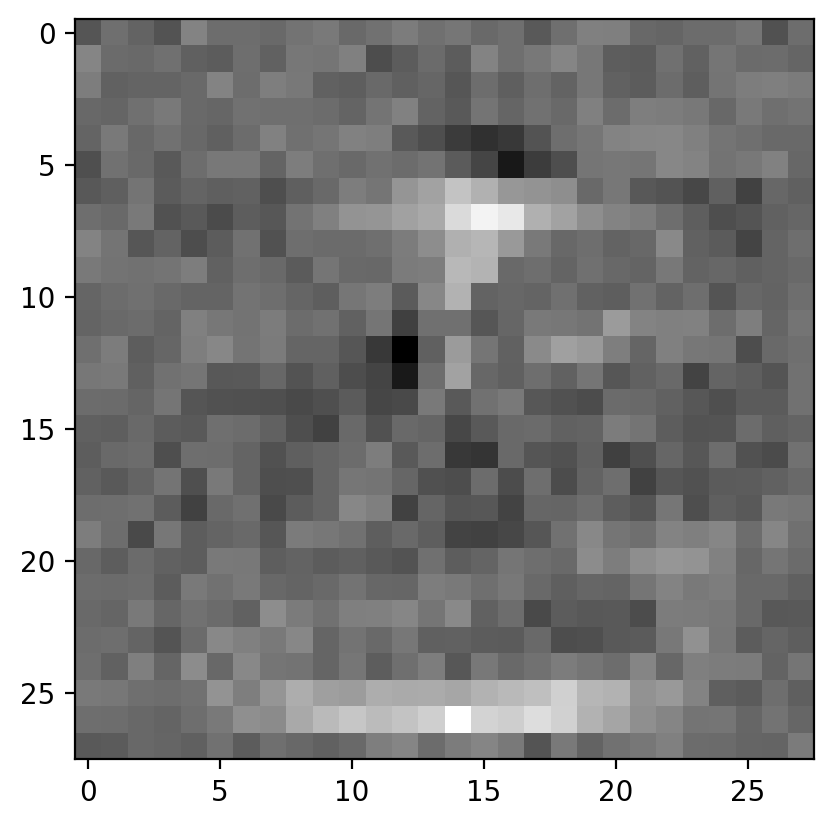

In [13]:
plt.imshow(weights[:-1].reshape(28, 28), cmap="gray")
plt.show()

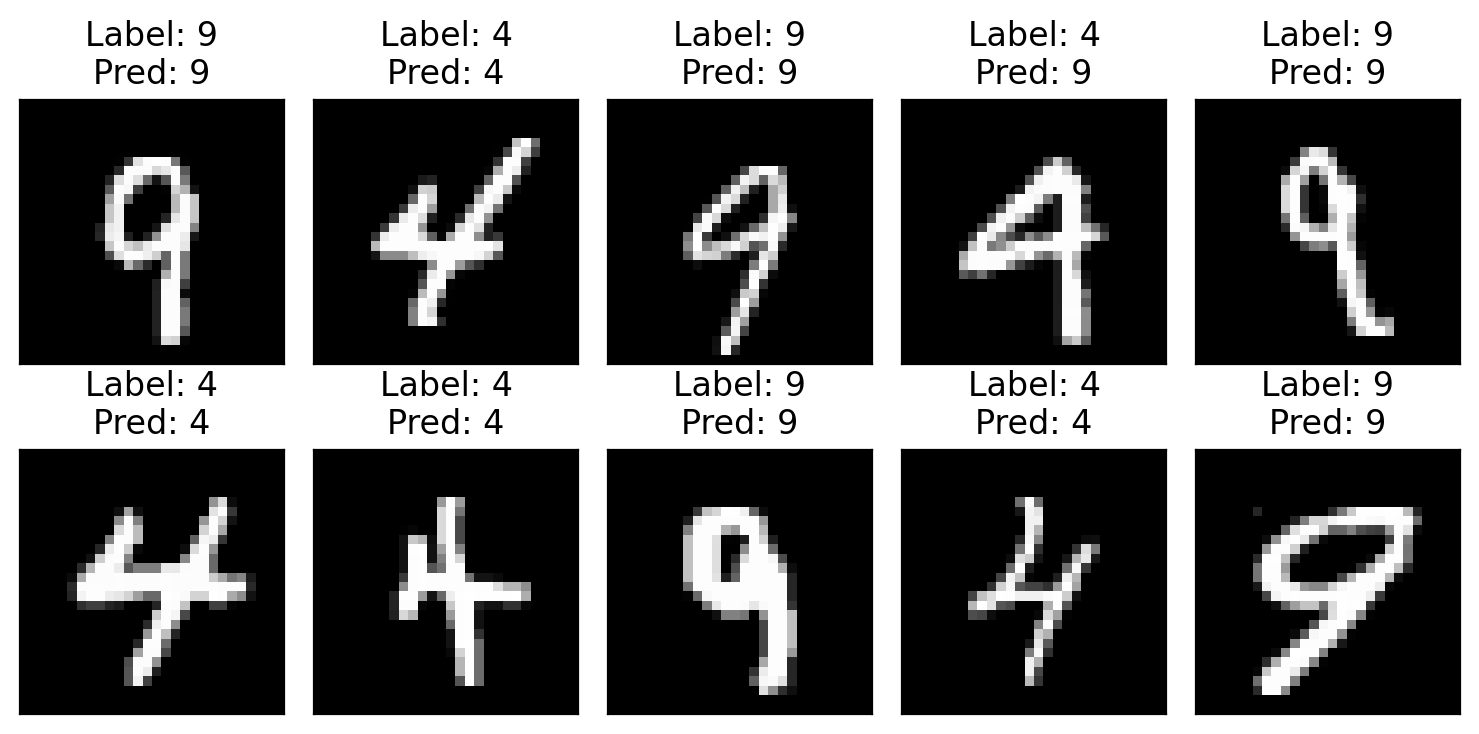

In [14]:
binary_test_images, binary_test_labels = shuffle_data(
    binary_test_images, binary_test_labels
)

plot_examples(
    binary_test_images[:10],
    labels=binary_test_labels[:10],
    predictions=[
        predict(normalize(image, 0, 1).flatten(), weights, bias_size=1, threshold=0.5)
        for image in binary_test_images[:10]
    ],
)

## Multiclass Adaline

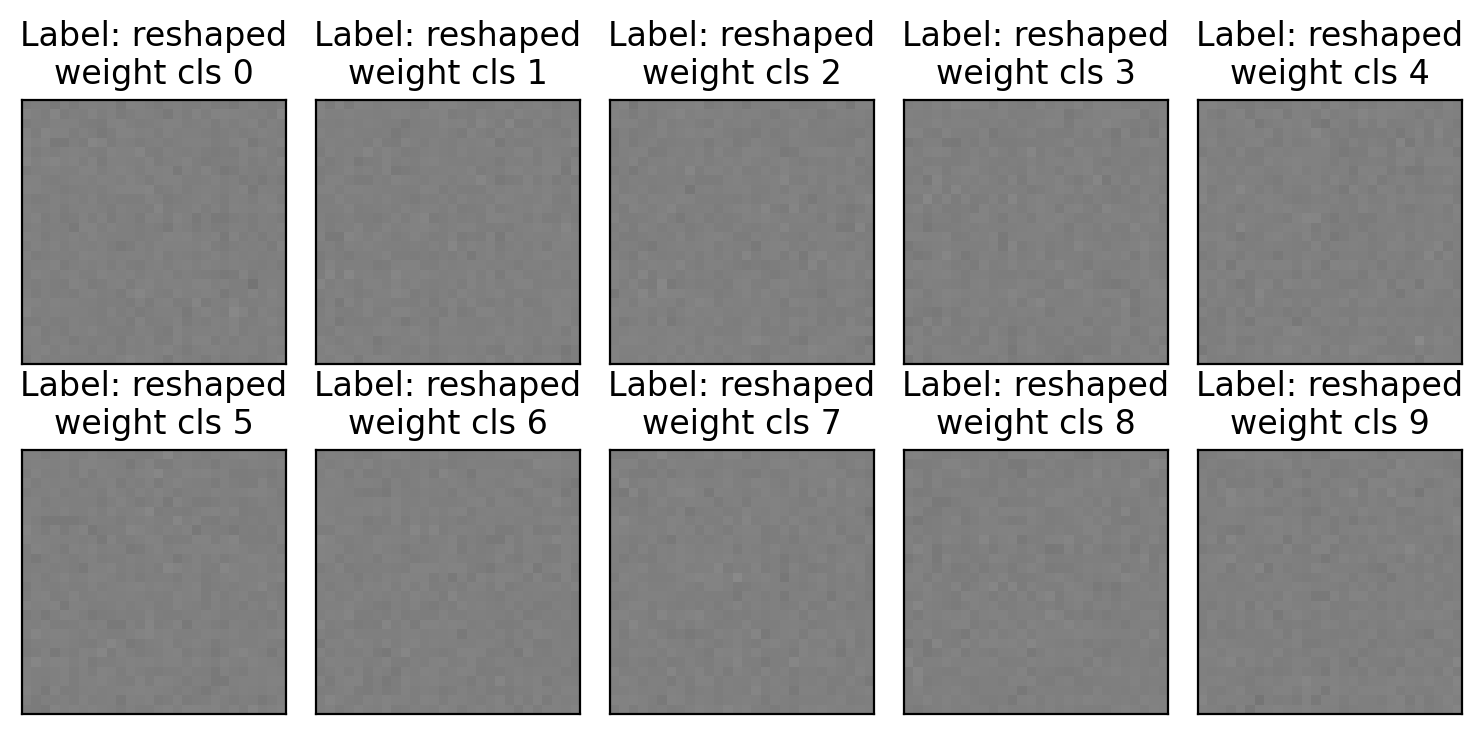

In [15]:
plot_examples(
    initialize_randn_weights(784, 10, 0, 0.5, 0.01).reshape(10, 28, 28),
    [f"reshaped\nweight cls {i}" for i in range(10)],
    num_col=5,
    num_row=2,
    vmin=0,
    vmax=1,
)

In [16]:
predict(
    normalize(train_images[0], 0, 1).flatten(),
    weights,
    backward=False,
    threshold=0.5,
)

9

In [17]:
weights, loss, pred = backward_pass(
    normalize(train_images[0], -1, 1).flatten(),
    train_labels[0],
    initialize_randn_weights(784, 10, 1, 0, 0.01),
)
print(f"Updated weights: {weights.shape}\nloss: {loss}")

Updated weights: (10, 785)
loss: 0.06726526252027686


In [18]:
weights, train_metrics = train_adaline(
    train_images,
    train_labels,
    epochs=10,
    learning_rate=0.00002,  # if you set the learning rate too high (eg = 0.1), you will encounter overfitting at it's best
    bias_size=1,
)

Epoch 0: Loss: 0.0295, Accuracy: 0.7094
Epoch 1: Loss: 0.0233, Accuracy: 0.8240
Epoch 2: Loss: 0.0221, Accuracy: 0.8361
Epoch 3: Loss: 0.0216, Accuracy: 0.8417
Epoch 4: Loss: 0.0212, Accuracy: 0.8460
Epoch 5: Loss: 0.0210, Accuracy: 0.8490
Epoch 6: Loss: 0.0208, Accuracy: 0.8504
Epoch 7: Loss: 0.0206, Accuracy: 0.8512
Epoch 8: Loss: 0.0205, Accuracy: 0.8526
Epoch 9: Loss: 0.0204, Accuracy: 0.8530


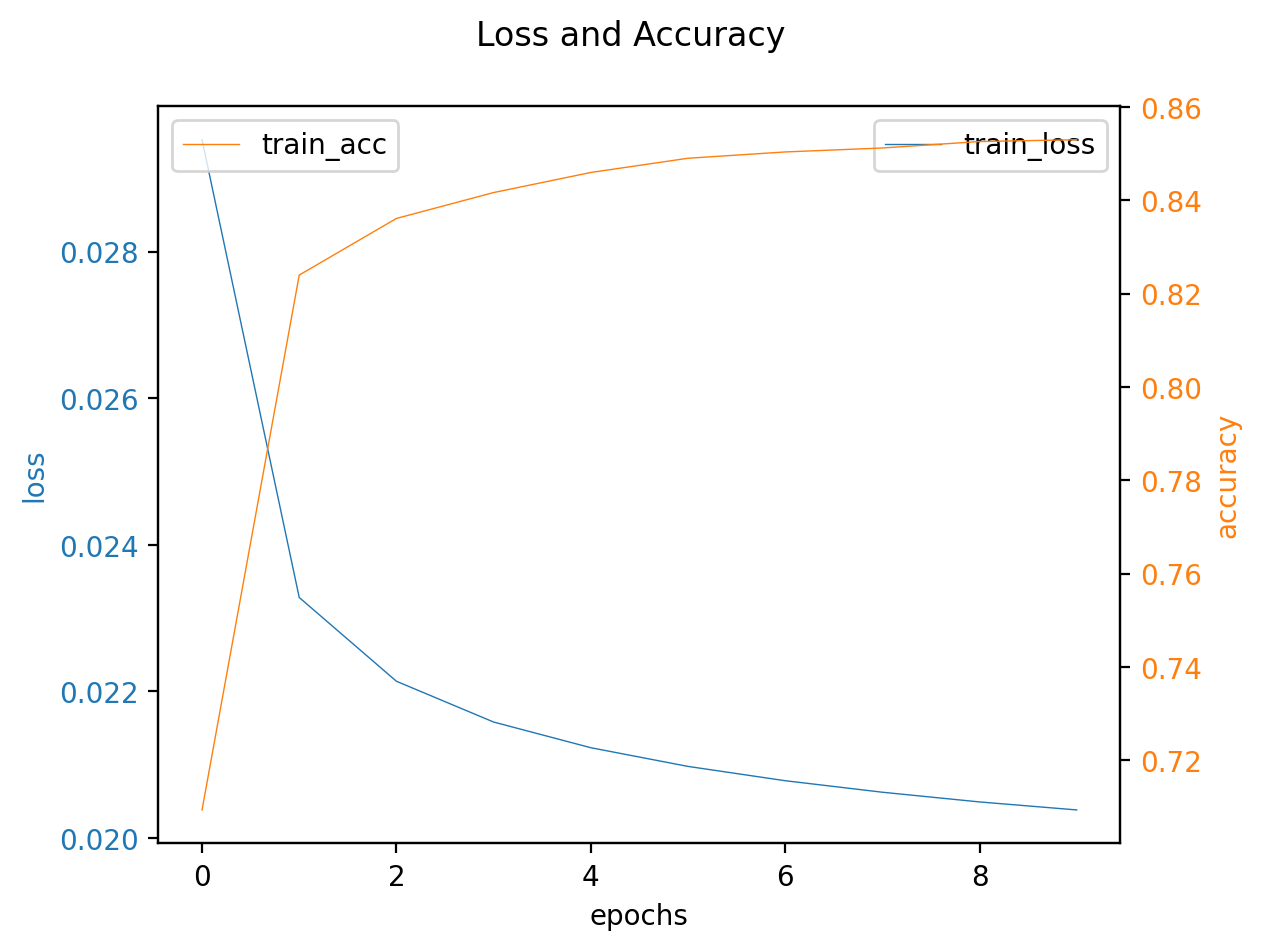

In [19]:
plot_metrics(train_metrics)

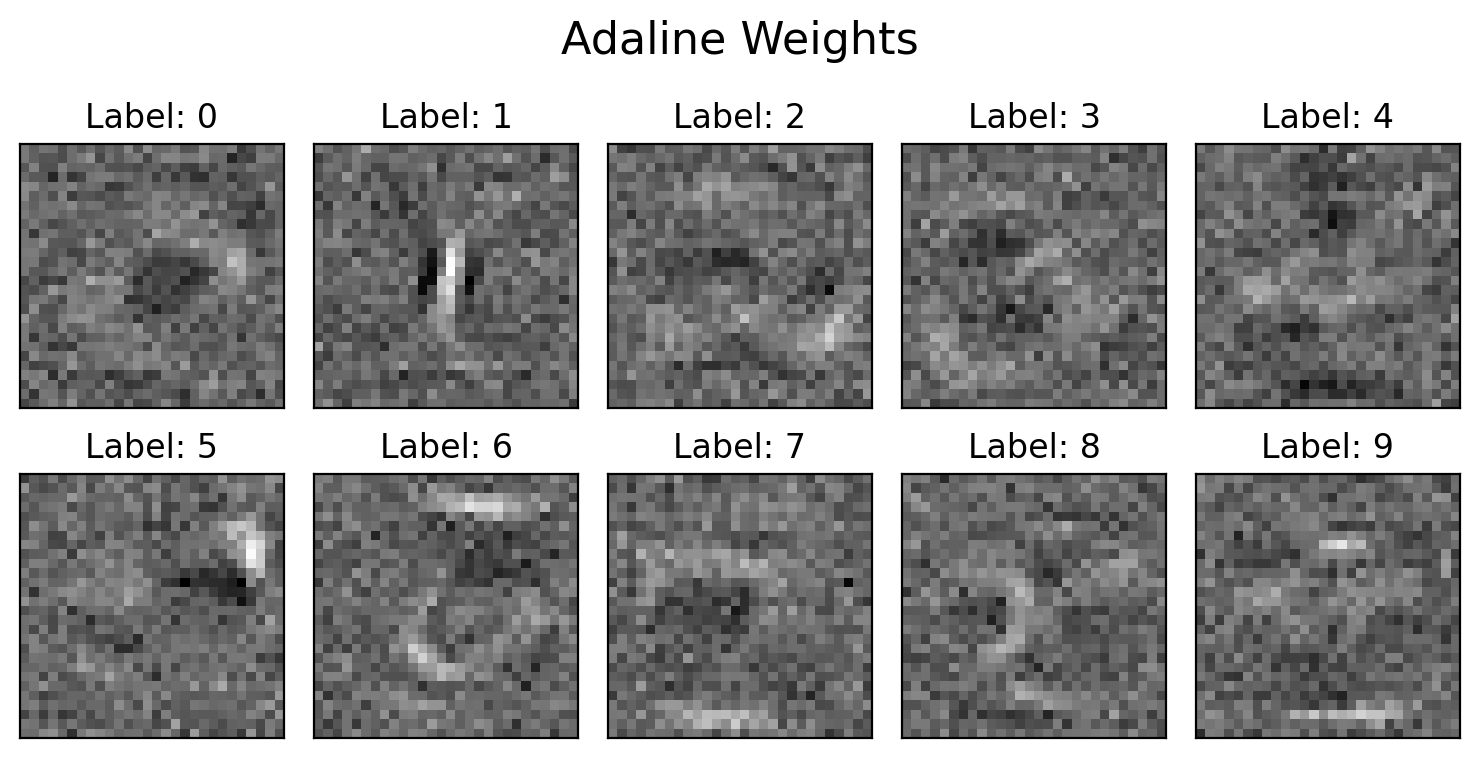

In [21]:
bias_size = 1

plot_examples(
    [weight[:-bias_size].reshape(28, -1) for weight in weights],
    labels=np.arange(len(weights)),
    fig_title="Adaline Weights",
    # vmin=0,
    # vmax=1, # you can set the min and max values to understand the small amounts of the weights better.
)

In [20]:
accuracy = eval_adaline(
    test_images,
    test_labels,
    weights,
    bias_size=1,
    threshold=0.5,
)

print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.857


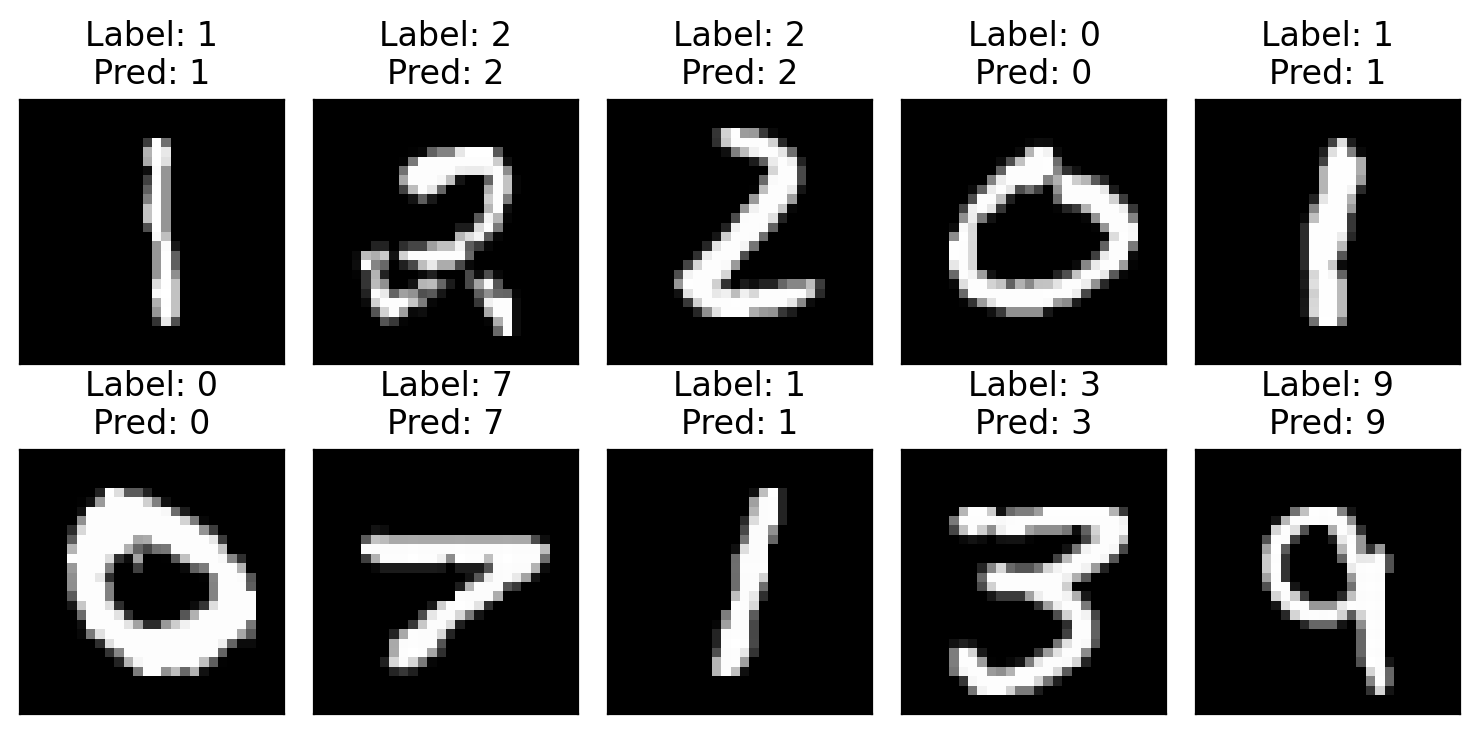

In [22]:
test_images, test_labels = shuffle_data(test_images, test_labels)

plot_examples(
    test_images[:10],
    labels=test_labels[:10],
    predictions=[
        predict(normalize(image, 0, 1).flatten(), weights, bias_size=1, threshold=0.5)
        for image in test_images[:10]
    ],
)